In [1]:
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os
from matplotlib.font_manager import FontProperties

In [2]:

def create_cost_summary():
    summary_data = []
    
    for gen in ["total_generation", "net_generation"]:
        for hydro in ["wet", "dry", "atlite"]:
            for elec in ["ALK", "PEM"]:
                for year in ["25", "30"]:
                    try:
                        path = f'Resources/{gen}/Scenario_{hydro}_{elec}_{year}/hex_cost_components.geojson'
                        data = gpd.read_file(path)
                        cost_data = data['Vientiane trucking production cost']
                        
                        summary_data.append({
                            'Generation': gen,
                            'Hydro Year': hydro,
                            'Electrolyser': elec,
                            'Year': f"20{year}",
                            'Min Cost': cost_data.min(),
                            'Max Cost': cost_data.max(),
                            'Mean Cost': cost_data.mean()
                        })
                    except Exception as e:
                        print(f"Could not process {path}: {e}")
                        continue
    
    df = pd.DataFrame(summary_data)
    df = df.round(2)
    
    # Save to CSV
    os.makedirs('Results', exist_ok=True)
    output_path = 'Results/cost_summary.csv'
    df.to_csv(output_path, index=False)
    
    return df

# Create and display summary
summary_df = create_cost_summary()
display(summary_df)

,Generation,Hydro Year,Electrolyser,Year,Min Cost,Max Cost,Mean Cost
0,total_generation,wet,ALK,2025,4.19,14.68,9.82
1,total_generation,wet,ALK,2030,3.90,15.45,7.67
2,total_generation,wet,PEM,2025,4.28,14.91,10.07
3,total_generation,wet,PEM,2030,3.99,15.75,7.94
4,total_generation,dry,ALK,2025,8.20,19.46,9.84
5,total_generation,dry,ALK,2030,6.49,15.45,7.68
6,total_generation,dry,PEM,2025,8.42,19.82,10.09
7,total_generation,dry,PEM,2030,6.75,15.75,7.95
8,total_generation,atlite,ALK,2025,5.92,14.68,9.79
9,total_generation,atlite,ALK,2030,5.13,15.45,7.65


In [3]:
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import numpy as np

def create_combined_waterfall():
    # Define scenarios and components
    scenarios = [
        ('wet', 'ALK'), ('wet', 'PEM'),
        ('dry', 'ALK'), ('dry', 'PEM'),
        ('atlite', 'ALK'), ('atlite', 'PEM')
    ]
    
    components = [
        ('battery costs portion', 'Battery'),
        ('electrolyzer portion', 'Electrolyzer'),
        ('H2 storage portion', 'H2 Storage'),
        ('wind portion', 'Wind'),
        ('solar portion', 'Solar'),
        ('hydro portion', 'Hydro')
    ]
    
    # Collect data
    data_dict = {}
    for hydro, elec in scenarios:
        path = f'Resources/total_generation/Scenario_{hydro}_{elec}_25/hex_cost_components.geojson'
        data = gpd.read_file(path)
        min_idx = data['Vientiane trucking production cost'].idxmin()
        min_hex = data.loc[min_idx]
        
        # Store values
        scenario_name = f"{hydro.capitalize()} {elec}"
        data_dict[scenario_name] = {
            'components': [min_hex[f'Vientiane LCOH - trucking {comp[0]}'] for comp in components],
            'total': min_hex['Vientiane trucking production cost']
        }
    
    # Create figure
    fig = go.Figure()
    
    # Set bar positions
    scenario_positions = np.arange(len(scenarios))
    bar_width = 0.15
    
    # Add component bars
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for idx, (_, comp_name) in enumerate(components):
        y_values = [data_dict[scen]['components'][idx] for scen in data_dict]
        
        fig.add_trace(go.Bar(
            name=comp_name,
            x=list(data_dict.keys()),
            y=y_values,
            marker_color=colors[idx]
        ))
    
    # Add total markers
    fig.add_trace(go.Scatter(
        name='Total Cost',
        x=list(data_dict.keys()),
        y=[data_dict[scen]['total'] for scen in data_dict],
        mode='markers+text',
        marker=dict(color='black', size=10),
        text=[f"{v:.2f}" for v in [data_dict[scen]['total'] for scen in data_dict]],
        textposition='top center'
    ))
    
    # Update layout
    fig.update_layout(
        barmode='relative',
        title='Cost Components Comparison - 2025 Scenarios',
        xaxis_title='Scenario',
        yaxis_title='LCOH (USD/kgH2)',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.05
        ),
        width=1000,
        height=600,
        margin=dict(r=150)
    )
    
    # Save figure
    fig.write_html("Results/waterfall_comparison_combined_2025.html")
    # fig.write_image("Results/waterfall_comparison_combined_2025.png", scale=2)
    
    return fig

# Execute
waterfall_fig = create_combined_waterfall()
waterfall_fig.show()

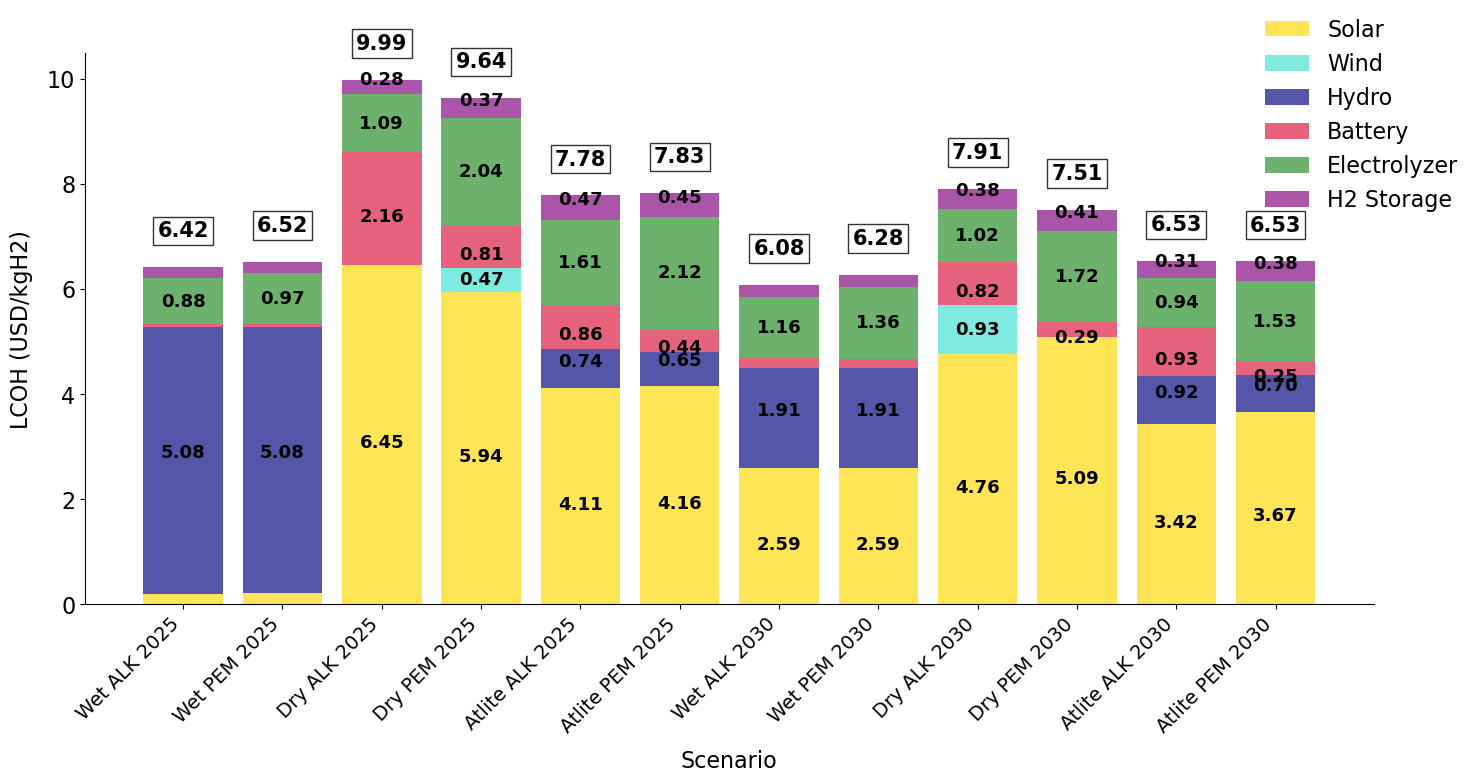

In [33]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def plot_cost_components():
    # Setup data
    scenarios = [
        ('wet', 'ALK', '25'), ('wet', 'PEM', '25'),
        ('dry', 'ALK', '25'), ('dry', 'PEM', '25'),
        ('atlite', 'ALK', '25'), ('atlite', 'PEM', '25'),
        ('wet', 'ALK', '30'), ('wet', 'PEM', '30'),
        ('dry', 'ALK', '30'), ('dry', 'PEM', '30'),
        ('atlite', 'ALK', '30'), ('atlite', 'PEM', '30')
    ]
    
    components = {
        'solar': {'col': 'solar portion', 'label': 'Solar', 
                 'color': '#FFD700AA'},  # golden yellow with alpha
        'wind': {'col': 'wind portion', 'label': 'Wind', 
                'color': '#40E0D0AA'},  # turquoise with alpha
        'hydro': {'col': 'hydro portion', 'label': 'Hydro', 
                 'color': '#000080AA'},  # deep blue with alpha
        'battery': {'col': 'battery costs portion', 'label': 'Battery', 
                   'color': '#DC143CAA'},  # crimson red with alpha
        'electrolyzer': {'col': 'electrolyzer portion', 'label': 'Electrolyzer', 
                        'color': '#228B22AA'},  # forest green with alpha
        'h2_storage': {'col': 'H2 storage portion', 'label': 'H2 Storage', 
                      'color': '#800080AA'}  # purple with alpha
    }
    
    # Initialize data arrays
    n_scenarios = len(scenarios)
    data_matrix = np.zeros((len(components), n_scenarios))
    totals = np.zeros(n_scenarios)
    
    # Load data
    for i, (hydro, elec, year) in enumerate(scenarios):
        data = gpd.read_file(f'Resources/net_generation/Scenario_{hydro}_{elec}_{year}/hex_cost_components.geojson')
        min_idx = data['Vientiane trucking production cost'].idxmin()
        
        for j, comp in enumerate(components.values()):
            data_matrix[j, i] = data.loc[min_idx, f'Vientiane LCOH - trucking {comp["col"]}']
        totals[i] = data.loc[min_idx, 'Vientiane trucking production cost']
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 8))
    bottom = np.zeros(n_scenarios)
    
    for idx, (_, comp) in enumerate(components.items()):
        values = data_matrix[idx, :]
        bars = ax.bar(range(n_scenarios), values, bottom=bottom, 
                     label=comp['label'], color=comp['color'])
        
        # Value labels - all black, larger font
        for i, v in enumerate(values):
            if v > 0.25:
                y_pos = bottom[i] + v/2
                offset = (idx % 3 - 1) * 0.15
                y_pos += offset
                ax.text(i, y_pos, f'{v:.2f}', 
                       ha='center', va='center', 
                       color='black',
                       fontsize=13, fontweight='bold')
        bottom += values
    
    # Styling with larger fonts
    ax.set_xlabel('Scenario', fontsize=16, labelpad=10)
    ax.set_ylabel('LCOH (USD/kgH2)', fontsize=16, labelpad=10)
    ax.set_xticks(range(n_scenarios))
    ax.set_xticklabels([f'{h.capitalize()} {e} 20{y}' for h, e, y in scenarios], 
                       rotation=45, ha='right', fontsize=14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=16)
    
    # Legend with larger font
    ax.legend(bbox_to_anchor=(0.9, 1.1), loc='upper left', 
             fontsize=16, frameon=False)
    
    # Total values with border and larger font
    for i, total in enumerate(totals):
        ax.text(i, bottom[i] + 0.5, f'{total:.2f}', 
                ha='center', va='bottom', fontsize=15, 
                fontweight='bold', color='black',
                bbox=dict(facecolor='white', edgecolor='black', 
                         alpha=0.8, pad=3))
    
    plt.tight_layout()
    return fig

# Execute
fig = plot_cost_components()
plt.show()

## Visualisation

In [6]:
gdf_data = gpd.read_file(f'Resources\\total_generation\\Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}\\hex_cost_components.geojson')
gdf_data = gdf_data.drop_duplicates(subset=['h3_index'])
gdf_data

,h3_index,n0,n1,n2,n3,n4,n5,waterbody_dist,waterway_dist,road_dist,...,Vientiane LCOH - trucking electrolyzer portion,Vientiane trucking H2 storage costs,Vientiane LCOH - trucking H2 storage portion,Vientiane trucking wind costs,Vientiane LCOH - trucking wind portion,Vientiane trucking solar costs,Vientiane LCOH - trucking solar portion,Vientiane trucking hydro costs,Vientiane LCOH - trucking hydro portion,geometry
0,85414d57fffffff,135,563,738,590,661,392,0.000000,0.0,0.0,...,1.446484,2.159456e+06,0.378852,0.0,0.0,2.537587e+07,4.451906,2.445510e+06,0.429037,"POLYGON ((103.46453 19.04274, 103.44104 19.134..."
1,85416b53fffffff,110,602,549,45,705,929,0.000000,0.0,0.0,...,1.631367,4.880991e+06,0.856314,0.0,0.0,3.164104e+07,5.551059,0.000000e+00,0.000000,"POLYGON ((104.46562 18.23086, 104.4426 18.3232..."
2,85414c07fffffff,408,496,244,234,603,473,11.131949,0.0,0.0,...,1.569703,4.296548e+06,0.753780,0.0,0.0,3.238446e+07,5.681485,0.000000e+00,0.000000,"POLYGON ((104.25779 19.06077, 104.23462 19.152..."
4,8541496bfffffff,388,90,804,750,619,671,11.131949,0.0,0.0,...,1.548623,2.964135e+06,0.520024,0.0,0.0,2.863745e+07,5.024114,0.000000e+00,0.000000,"POLYGON ((102.26097 20.24363, 102.23692 20.335..."
5,85414b53fffffff,536,271,380,193,0,0,22.263898,0.0,0.0,...,1.430644,5.209999e+06,0.914035,0.0,0.0,2.949706e+07,5.174922,0.000000e+00,0.000000,"POLYGON ((103.13781 21.00166, 103.11404 21.092..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,85659293fffffff,576,61,33,785,464,82,0.000000,0.0,0.0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,"POLYGON ((106.83208 14.92253, 106.81028 15.015..."
1132,8564b3dbfffffff,882,871,312,904,48,310,0.000000,0.0,0.0,...,1.480339,4.968572e+06,0.871679,0.0,0.0,3.032633e+07,5.320409,0.000000e+00,0.000000,"POLYGON ((101.50712 18.33107, 101.48293 18.423..."
1133,856490cffffffff,243,153,425,375,719,341,0.000000,0.0,0.0,...,1.520971,4.979844e+06,0.873657,0.0,0.0,2.982003e+07,5.231585,0.000000e+00,0.000000,"POLYGON ((100.70284 20.34594, 100.6782 20.4374..."
1134,85659067fffffff,30,792,693,228,129,492,0.000000,0.0,0.0,...,1.401979,6.273436e+06,1.100603,0.0,0.0,2.919535e+07,5.121991,0.000000e+00,0.000000,"POLYGON ((105.84584 14.71295, 105.82364 14.806..."


In [4]:
hydro_year = "wet" # wet dry atlite
scenario_year = "30" # 25 30
electrolyser_type = "ALK" # ALK PEM

# gdf_data = gpd.read_file(f'Resources\\net_generation\\Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}\\hex_cost_components.geojson')
gdf_data = gpd.read_file(f'Resources\\Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}\\hex_cost_components.geojson')
gdf_data = gdf_data.drop_duplicates(subset=['h3_index'])

generate_waterfall_chart(gdf_data, 'trucking')

vmin = gdf_data["Vientiane trucking production cost"].min() - 0.5
plot_full_cost_map(
    gdf_data, 'Vientiane', 'Vientiane trucking production cost', 
    #r'Resources\Scenario_dry_ALK_25\Visualisation\visualisation_lowest_cost.png', 
    vmin=vmin, vmax=vmax
)

plot_cost_distribution(gdf_data, 
                       'Vientiane trucking production cost', 
                       'cost_distribution.png', 15)

DataSourceError: Resources\Scenario_wet_ALK_30\hex_cost_components.geojson: No such file or directory

In [35]:
gdf_data["Vientiane trucking production cost"].min()

3.895214108003592

### Plot all lines in one plot

In [36]:
def ensure_directory_exists(path):
    """Create directory if it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path)
        
def load_and_process_data(file_path, cost_column, max_cost, max_x):
    """
    Load and process cost data from GeoJSON file.
    
    Args:
        file_path (str): Path to GeoJSON file
        cost_column (str): Name of cost column
        max_cost (float): Maximum cost threshold
        max_x (int): Maximum x-axis value
        
    Returns:
        tuple: (x_values, costs, initial_value) or (None, None, None) if error
    """
    try:
        # Load data
        gdf = gpd.read_file(file_path)
        
        # Filter and sort costs
        mask = (gdf[cost_column] > 0) & (gdf[cost_column] <= max_cost)
        costs = gdf[mask][cost_column].sort_values()
        
        # Create x values
        x_values = np.arange(len(costs))
        
        # Get initial value
        initial_value = costs.iloc[0] if len(costs) > 0 else None
        
        # Limit to max_x
        mask = x_values <= max_x
        x_values = x_values[mask]
        costs = costs[mask]
        
        return x_values, costs, initial_value
        
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None, None, None

In [31]:
def plot_combined_cost_distribution(max_cost=15, max_x=250):
    """Creates combined cost distribution plot for net and total generation"""
    output_dir = os.path.join('Visualisation', 'comparisons')
    ensure_directory_exists(output_dir)
    
    scenarios = [
        ('wet', 'ALK', '25'), ('wet', 'ALK', '30'),
        ('wet', 'PEM', '25'), ('wet', 'PEM', '30'),
        ('dry', 'ALK', '25'), ('dry', 'ALK', '30'),
        ('dry', 'PEM', '25'), ('dry', 'PEM', '30'),
        ('atlite', 'ALK', '25'), ('atlite', 'PEM', '25'),
        ('atlite', 'ALK', '30'), ('atlite', 'PEM', '30'),
    ]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#17becf', '#bcbd22', '#c49c94', '#f7b6d2']
    
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white', dpi=300)
    ax.set_facecolor('white')
    
    net_lines = []
    total_lines = []
    
    for (hydro_year, electrolyser_type, scenario_year), color in zip(scenarios, colors):
        x_net, costs_net, initial_net = load_and_process_data(
            f'Resources/net_generation/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        x_total, costs_total, initial_total = load_and_process_data(
            f'Resources/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        label_base = f'{hydro_year.capitalize()} {electrolyser_type} 20{scenario_year}'
        
        if x_net is not None and initial_net is not None:
            line = ax.plot(x_net, costs_net, color=color, linewidth=1.2, linestyle='--', 
                         label=label_base)[0]
            ax.plot(0, initial_net, '^', color=color, markersize=3, 
                   markerfacecolor='none', markeredgewidth=2)
            net_lines.append((label_base, line))
            
        if x_total is not None and initial_total is not None:
            line = ax.plot(x_total, costs_total, color=color, linewidth=1.2,
                         label=label_base)[0]
            ax.plot(0, initial_total, 'o', color=color, markersize=5, 
                   markerfacecolor=color, markeredgewidth=0)
            total_lines.append((label_base, line))
    
    # Create custom legend with headers
    net_header = ax.plot([], [], '', color='none', label='Net Generation')[0]
    total_header = ax.plot([], [], '', color='none', label='Total Generation')[0]
    
    net_lines.sort(key=lambda x: x[0])
    total_lines.sort(key=lambda x: x[0])
    
    legend_elements = [net_header] + [line for _, line in net_lines] + \
                     [total_header] + [line for _, line in total_lines]
    legend_labels = ['Net Generation'] + [label for label, _ in net_lines] + \
                   ['Total Generation'] + [label for label, _ in total_lines]
    
    # Create legend with custom font properties
    legend = ax.legend(legend_elements, legend_labels, 
                      bbox_to_anchor=(1.05, 1), loc='upper left', 
                      fontsize=10) # 
    
    # Set font properties for headers
    header_font = {'size': 10, 'weight': 'bold'}
    legend.get_texts()[0].set_fontproperties(FontProperties(**header_font))
    legend.get_texts()[len(net_lines) + 1].set_fontproperties(FontProperties(**header_font))
    
    ax.set_xlabel('Cumulative Production Potential (kt)', fontsize=12)
    ax.set_ylabel('LCOH (USD/kgH2)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_ylim(3, max_cost)
    ax.set_xlim(-0.5, max_x)
    
    tick_spacing = 1
    ticks = np.arange(0, max_x + tick_spacing, tick_spacing)
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(int(x)) for x in ticks])
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'cost_distribution_net_vs_total.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig)

In [37]:
from matplotlib.font_manager import FontProperties
plot_combined_cost_distribution(10.5,4)

In [46]:
def plot_combined_cost_distribution_total(max_cost=15, max_x=250):
    """Creates combined cost distribution plot for net and total generation"""
    output_dir = os.path.join('Visualisation', 'comparisons')
    ensure_directory_exists(output_dir)
    
    scenarios = [
        ('wet', 'ALK', '25'), ('wet', 'ALK', '30'),
        ('wet', 'PEM', '25'), ('wet', 'PEM', '30'),
        ('dry', 'ALK', '25'), ('dry', 'ALK', '30'),
        ('dry', 'PEM', '25'), ('dry', 'PEM', '30'),
        ('atlite', 'ALK', '25'), ('atlite', 'PEM', '25'),
        ('atlite', 'ALK', '30'), ('atlite', 'PEM', '30'),
    ]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#17becf', '#bcbd22', '#c49c94', '#f7b6d2']
    
    fig, ax = plt.subplots(figsize=(4, 6), facecolor='white', dpi=300)
    ax.set_facecolor('white')
    
    net_lines = []
    total_lines = []
    
    for (hydro_year, electrolyser_type, scenario_year), color in zip(scenarios, colors):
        x_net, costs_net, initial_net = load_and_process_data(
            f'Resources/net_generation/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        x_total, costs_total, initial_total = load_and_process_data(
            f'Resources/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        label_base = f'{hydro_year.capitalize()} {electrolyser_type} 20{scenario_year}'
        
        if x_net is not None and initial_net is not None:
            line = ax.plot(x_net, costs_net, color=color, linewidth=1.2, linestyle='--', 
                         label=label_base)[0]
            ax.plot(0, initial_net, '^', color=color, markersize=3, 
                   markerfacecolor='none', markeredgewidth=2)
            net_lines.append((label_base, line))
            
        if x_total is not None and initial_total is not None:
            line = ax.plot(x_total, costs_total, color=color, linewidth=1.2,
                         label=label_base)[0]
            ax.plot(0, initial_total, 'o', color=color, markersize=5, 
                   markerfacecolor=color, markeredgewidth=0)
            total_lines.append((label_base, line))
    
    # # Create custom legend with headers
    # net_header = ax.plot([], [], '', color='none', label='Net Generation')[0]
    # total_header = ax.plot([], [], '', color='none', label='Total Generation')[0]
    
    # net_lines.sort(key=lambda x: x[0])
    # total_lines.sort(key=lambda x: x[0])
    
    # legend_elements = [net_header] + [line for _, line in net_lines] + \
    #                  [total_header] + [line for _, line in total_lines]
    # legend_labels = ['Net Generation'] + [label for label, _ in net_lines] + \
    #                ['Total Generation'] + [label for label, _ in total_lines]
    
    # # Create legend with custom font properties
    # legend = ax.legend(legend_elements, legend_labels, 
    #                   bbox_to_anchor=(1.05, 1), loc='upper left', 
    #                   fontsize=10) # 
    
    # # Set font properties for headers
    # header_font = {'size': 10, 'weight': 'bold'}
    # legend.get_texts()[0].set_fontproperties(FontProperties(**header_font))
    # legend.get_texts()[len(net_lines) + 1].set_fontproperties(FontProperties(**header_font))
    
    ax.set_xlabel('Cumulative Production Potential (kt)', fontsize=12)
    ax.set_ylabel('LCOH (USD/kgH2)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_ylim(3, max_cost)
    ax.set_xlim(-0.5, max_x)
    
    tick_spacing = 100
    ticks = np.arange(0, max_x + tick_spacing, tick_spacing)
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(int(x)) for x in ticks])
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'cost_distribution_net_vs_total_full.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig)

In [47]:
plot_combined_cost_distribution_total(20,400)

## Hexagon map

In [21]:
# Function to plot the full cost map
def plot_full_cost_map(hexagons, demand_center, cost_column, save_path, provinces=None, vmin=None, vmax=None):
    """
    Plots a map showing production costs in USD/kg with province boundaries.
    
    Parameters:
    - hexagons: GeoDataFrame containing the hexagons and data.
    - demand_center: Name of the demand center (e.g., 'Vientiane').
    - cost_column: The specific column for production cost (e.g., 'Vientiane trucking production cost').
    - save_path: File path to save the PNG image.
    - provinces: GeoDataFrame for province boundaries.
    - vmin: Minimum value for the color scale (optional).
    - vmax: Maximum value for the color scale (optional).
    """
    crs = ccrs.PlateCarree()  # Example projection, adjust as needed
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': crs})
    ax.set_axis_off()

    hexagons_copy = hexagons.copy()

    # Mask zero values
    zero_mask = hexagons_copy[cost_column] == 0
    hexagons_copy.loc[zero_mask, cost_column] = np.nan

    # Plot the province boundaries if provided (this will be below the hexagons)
    if provinces is not None:
        provinces.to_crs(crs.proj4_init).plot(
            ax=ax, color='none', edgecolor='black', linewidth=0.5)

    # Plot the hexagons with production cost, applying the min/max thresholds
    plot = hexagons_copy.to_crs(crs.proj4_init).plot(
        ax=ax,
        column=cost_column,
        legend=True,
        cmap='Greens_r',
        legend_kwds={
            'label': 'LCOH (USD/kgH2)',
            'orientation': 'vertical',
            'shrink': 0.5,
            'pad': 0.05,
            'anchor': (-1.1, 1.0)
        },
        missing_kwds={
            "color": "lightgrey",
            "label": "No Data or Zero",
        },
        edgecolor='black',
        linewidth=0.2,
        vmin=vmin,  # Set the minimum value for the color scale
        vmax=vmax   # Set the maximum value for the color scale
    )

    # Adjust legend position to be on the right side and closer to the center
    if plot.get_legend() is not None:
        legend = plot.get_legend()
        legend.set_bbox_to_anchor((1, 0.5))
        legend.set_frame_on(True)

    plt.show()

    # Save the figure
    # fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


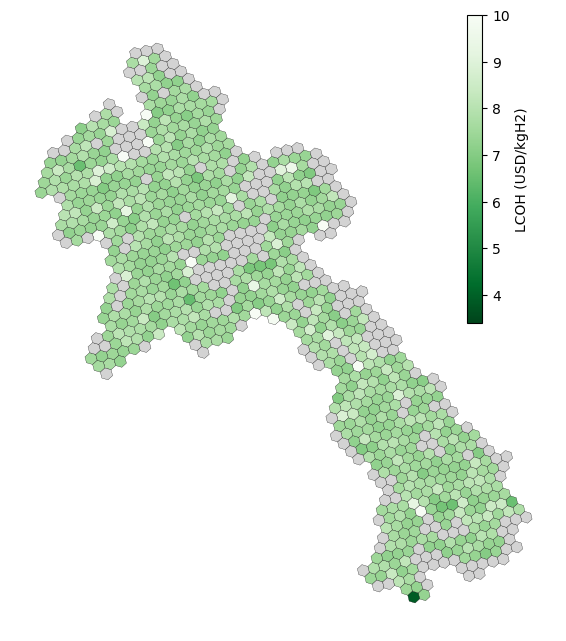

In [ ]:
gdf_data = gdf_data.drop_duplicates(subset=['h3_index'])
vmin = gdf_data["Vientiane trucking production cost"].min() - 0.5
vmax = 10

plot_full_cost_map(
    gdf_data, 'Vientiane', 'Vientiane trucking production cost', 
    r'Resources\Scenario_dry_ALK_25\Visualisation\visualisation_lowest_cost.png', 
    vmin=vmin, vmax=vmax
)

In [294]:
def plot_full_cost_map(hexagons, demand_center, cost_column, provinces=None, vmin=None, vmax=None):
    """Plots a map showing production costs in discrete color bins using Greens_r colormap"""
    # Define bins and get colors from Greens_r
    bins = [3, 4, 5, 6, 7, 8, 9, 10, float('inf')]
    labels = ['3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10+']
    
    # Get N colors from Greens_r and reverse them
    greens = plt.cm.Greens_r(np.linspace(0.2, 0.8, len(labels)))
    cmap = mcolors.ListedColormap(greens)
    
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': crs}, dpi=300)
    ax.set_axis_off()

    hexagons_copy = hexagons.copy()
    zero_mask = hexagons_copy[cost_column] == 0
    hexagons_copy.loc[zero_mask, cost_column] = np.nan

    # Create normalization for discrete bins
    norm = mcolors.BoundaryNorm(bins, cmap.N)

    if provinces is not None:
        provinces.to_crs(crs.proj4_init).plot(
            ax=ax, color='none', edgecolor='black', linewidth=0.5)

    plot = hexagons_copy.to_crs(crs.proj4_init).plot(
        ax=ax,
        column=cost_column,
        cmap=cmap,
        norm=norm,
        legend=False,
        missing_kwds={
            "color": "lightgrey",
            "label": "Not feasible",
        },
        edgecolor='black',
        linewidth=0.2
    )
    

    # Create custom legend with Greens_r colors
    legend_elements = [Patch(facecolor=greens[i], edgecolor='black', label=label)
                      for i, label in enumerate(labels)]
    legend_elements.append(Patch(facecolor='lightgrey', edgecolor='black', 
                               label='Not feasible'))

    legend = ax.legend(handles=legend_elements,
                      title='LCOH (USD/kgH2)',
                      bbox_to_anchor=(0.7, 0.8),
                      loc='center left',
                      frameon=True,
                      fontsize=10)
    legend.get_title().set_fontsize(12)

    plt.show()
    # fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig)

In [30]:
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

vmin = gdf_data["Vientiane trucking production cost"].min() - 0.5
vmax = 15

plot_full_cost_map(
    gdf_data, 'Vientiane', 'Vientiane pipeline production cost', 
    vmin=vmin, vmax=vmax
)

TypeError: plot_full_cost_map() missing 1 required positional argument: 'save_path'

## Cost Curve

In [26]:
def plot_cost_distribution(hexagons, cost_column, save_path):
    """Creates clean line plot of production costs vs cumulative potential"""
    # Prep data
    costs = hexagons[hexagons[cost_column] > 0][cost_column].sort_values()
    x_values = np.arange(len(costs)) * 1000
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot smooth line
    ax.plot(x_values, costs, color='#2ecc71', linewidth=2)
    
    # Fill area under curve
    ax.fill_between(x_values, costs, alpha=0.2, color='#2ecc71')
    
    # Styling
    ax.set_xlabel('Production Potential (kt)', fontsize=10)
    ax.set_ylabel('LCOH (USD/kgH2)', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Minimal x-ticks every 10kt
    step = 10000
    ax.set_xticks(np.arange(0, len(costs) * 1000, step))
    ax.set_xticklabels([f'{int(x/1000)}k' for x in ax.get_xticks()])
    
    plt.tight_layout()
    plt.show()
    
    # fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
plot_cost_distribution(gdf_data, 'Vientiane trucking production cost', 'cost_distribution.png', 10)

TypeError: plot_cost_distribution() takes 3 positional arguments but 4 were given

## Plot all lines in one Plot

In [7]:
def ensure_directory_exists(path):
    """Create directory if it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path)
        
def load_and_process_data(file_path, cost_column, max_cost, max_x):
    """Helper function to safely load and process data"""
    try:
        gdf = gpd.read_file(file_path)
        mask = (gdf[cost_column] > 0) & (gdf[cost_column] <= max_cost)
        costs = gdf[mask][cost_column].sort_values()
        x_values = np.arange(len(costs))
        mask = x_values <= max_x
        return x_values[mask], costs[mask]
    except Exception:
        return None, None


In [28]:
def plot_combined_cost_distribution(max_cost=15, max_x=250):
    """Creates combined cost distribution plot for net and total generation"""
    output_dir = os.path.join('Visualisation', 'comparisons')
    ensure_directory_exists(output_dir)
    
    scenarios = [
        ('wet', 'ALK', '25'), ('wet', 'ALK', '30'),
        ('wet', 'PEM', '25'), ('wet', 'PEM', '30'),
        ('dry', 'ALK', '25'), ('dry', 'ALK', '30'),
        ('dry', 'PEM', '25'), ('dry', 'PEM', '30'),
        ('atlite', 'ALK', '25'), ('atlite', 'PEM', '25'),
        ('atlite', 'ALK', '30'), ('atlite', 'PEM', '30')
    ]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#17becf', '#bcbd22']
    
    fig, ax = plt.subplots(figsize=(10, 5), facecolor='white', dpi=300)
    ax.set_facecolor('white')
    
    net_lines = []
    total_lines = []
    
    for (hydro_year, electrolyser_type, scenario_year), color in zip(scenarios, colors):
        x_net, costs_net, initial_net = load_and_process_data(
            f'Resources/net_generation/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        x_total, costs_total, initial_total = load_and_process_data(
            f'Resources/Scenario_{hydro_year}_{electrolyser_type}_{scenario_year}/hex_cost_components.geojson',
            'Vientiane trucking production cost',
            max_cost,
            max_x
        )
        
        label_base = f'{hydro_year.capitalize()} {electrolyser_type} 20{scenario_year}'
        
        if x_net is not None and initial_net is not None:
            line = ax.plot(x_net, costs_net, color=color, linewidth=1.2, linestyle='--', 
                         label=label_base)[0]
            ax.plot(0, initial_net, '^', color=color, markersize=3, 
                   markerfacecolor='none', markeredgewidth=2)
            net_lines.append((label_base, line))
            
        if x_total is not None and initial_total is not None:
            line = ax.plot(x_total, costs_total, color=color, linewidth=1.2,
                         label=label_base)[0]
            ax.plot(0, initial_total, 'o', color=color, markersize=5, 
                   markerfacecolor=color, markeredgewidth=0)
            total_lines.append((label_base, line))
    
    # Create custom legend with headers
    net_header = ax.plot([], [], '', color='none', label='Net Generation')[0]
    total_header = ax.plot([], [], '', color='none', label='Total Generation')[0]
    
    net_lines.sort(key=lambda x: x[0])
    total_lines.sort(key=lambda x: x[0])
    
    legend_elements = [net_header] + [line for _, line in net_lines] + \
                     [total_header] + [line for _, line in total_lines]
    legend_labels = ['Net Generation'] + [label for label, _ in net_lines] + \
                   ['Total Generation'] + [label for label, _ in total_lines]
    
    # Create legend with custom font properties
    legend = ax.legend(legend_elements, legend_labels, 
                      bbox_to_anchor=(1.05, 1), loc='upper left', 
                      fontsize=10) # 
    
    # Set font properties for headers
    header_font = {'size': 10, 'weight': 'bold'}
    legend.get_texts()[0].set_fontproperties(FontProperties(**header_font))
    legend.get_texts()[len(net_lines) + 1].set_fontproperties(FontProperties(**header_font))
    
    ax.set_xlabel('Cumulative Production Potential (kt)', fontsize=12)
    ax.set_ylabel('LCOH (USD/kgH2)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_ylim(3, max_cost)
    ax.set_xlim(-0.5, max_x)
    
    tick_spacing = 50
    ticks = np.arange(0, max_x + tick_spacing, tick_spacing)
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(int(x)+1) for x in ticks])
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'cost_distribution_net_vs_total.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig)

ValueError: not enough values to unpack (expected 3, got 2)

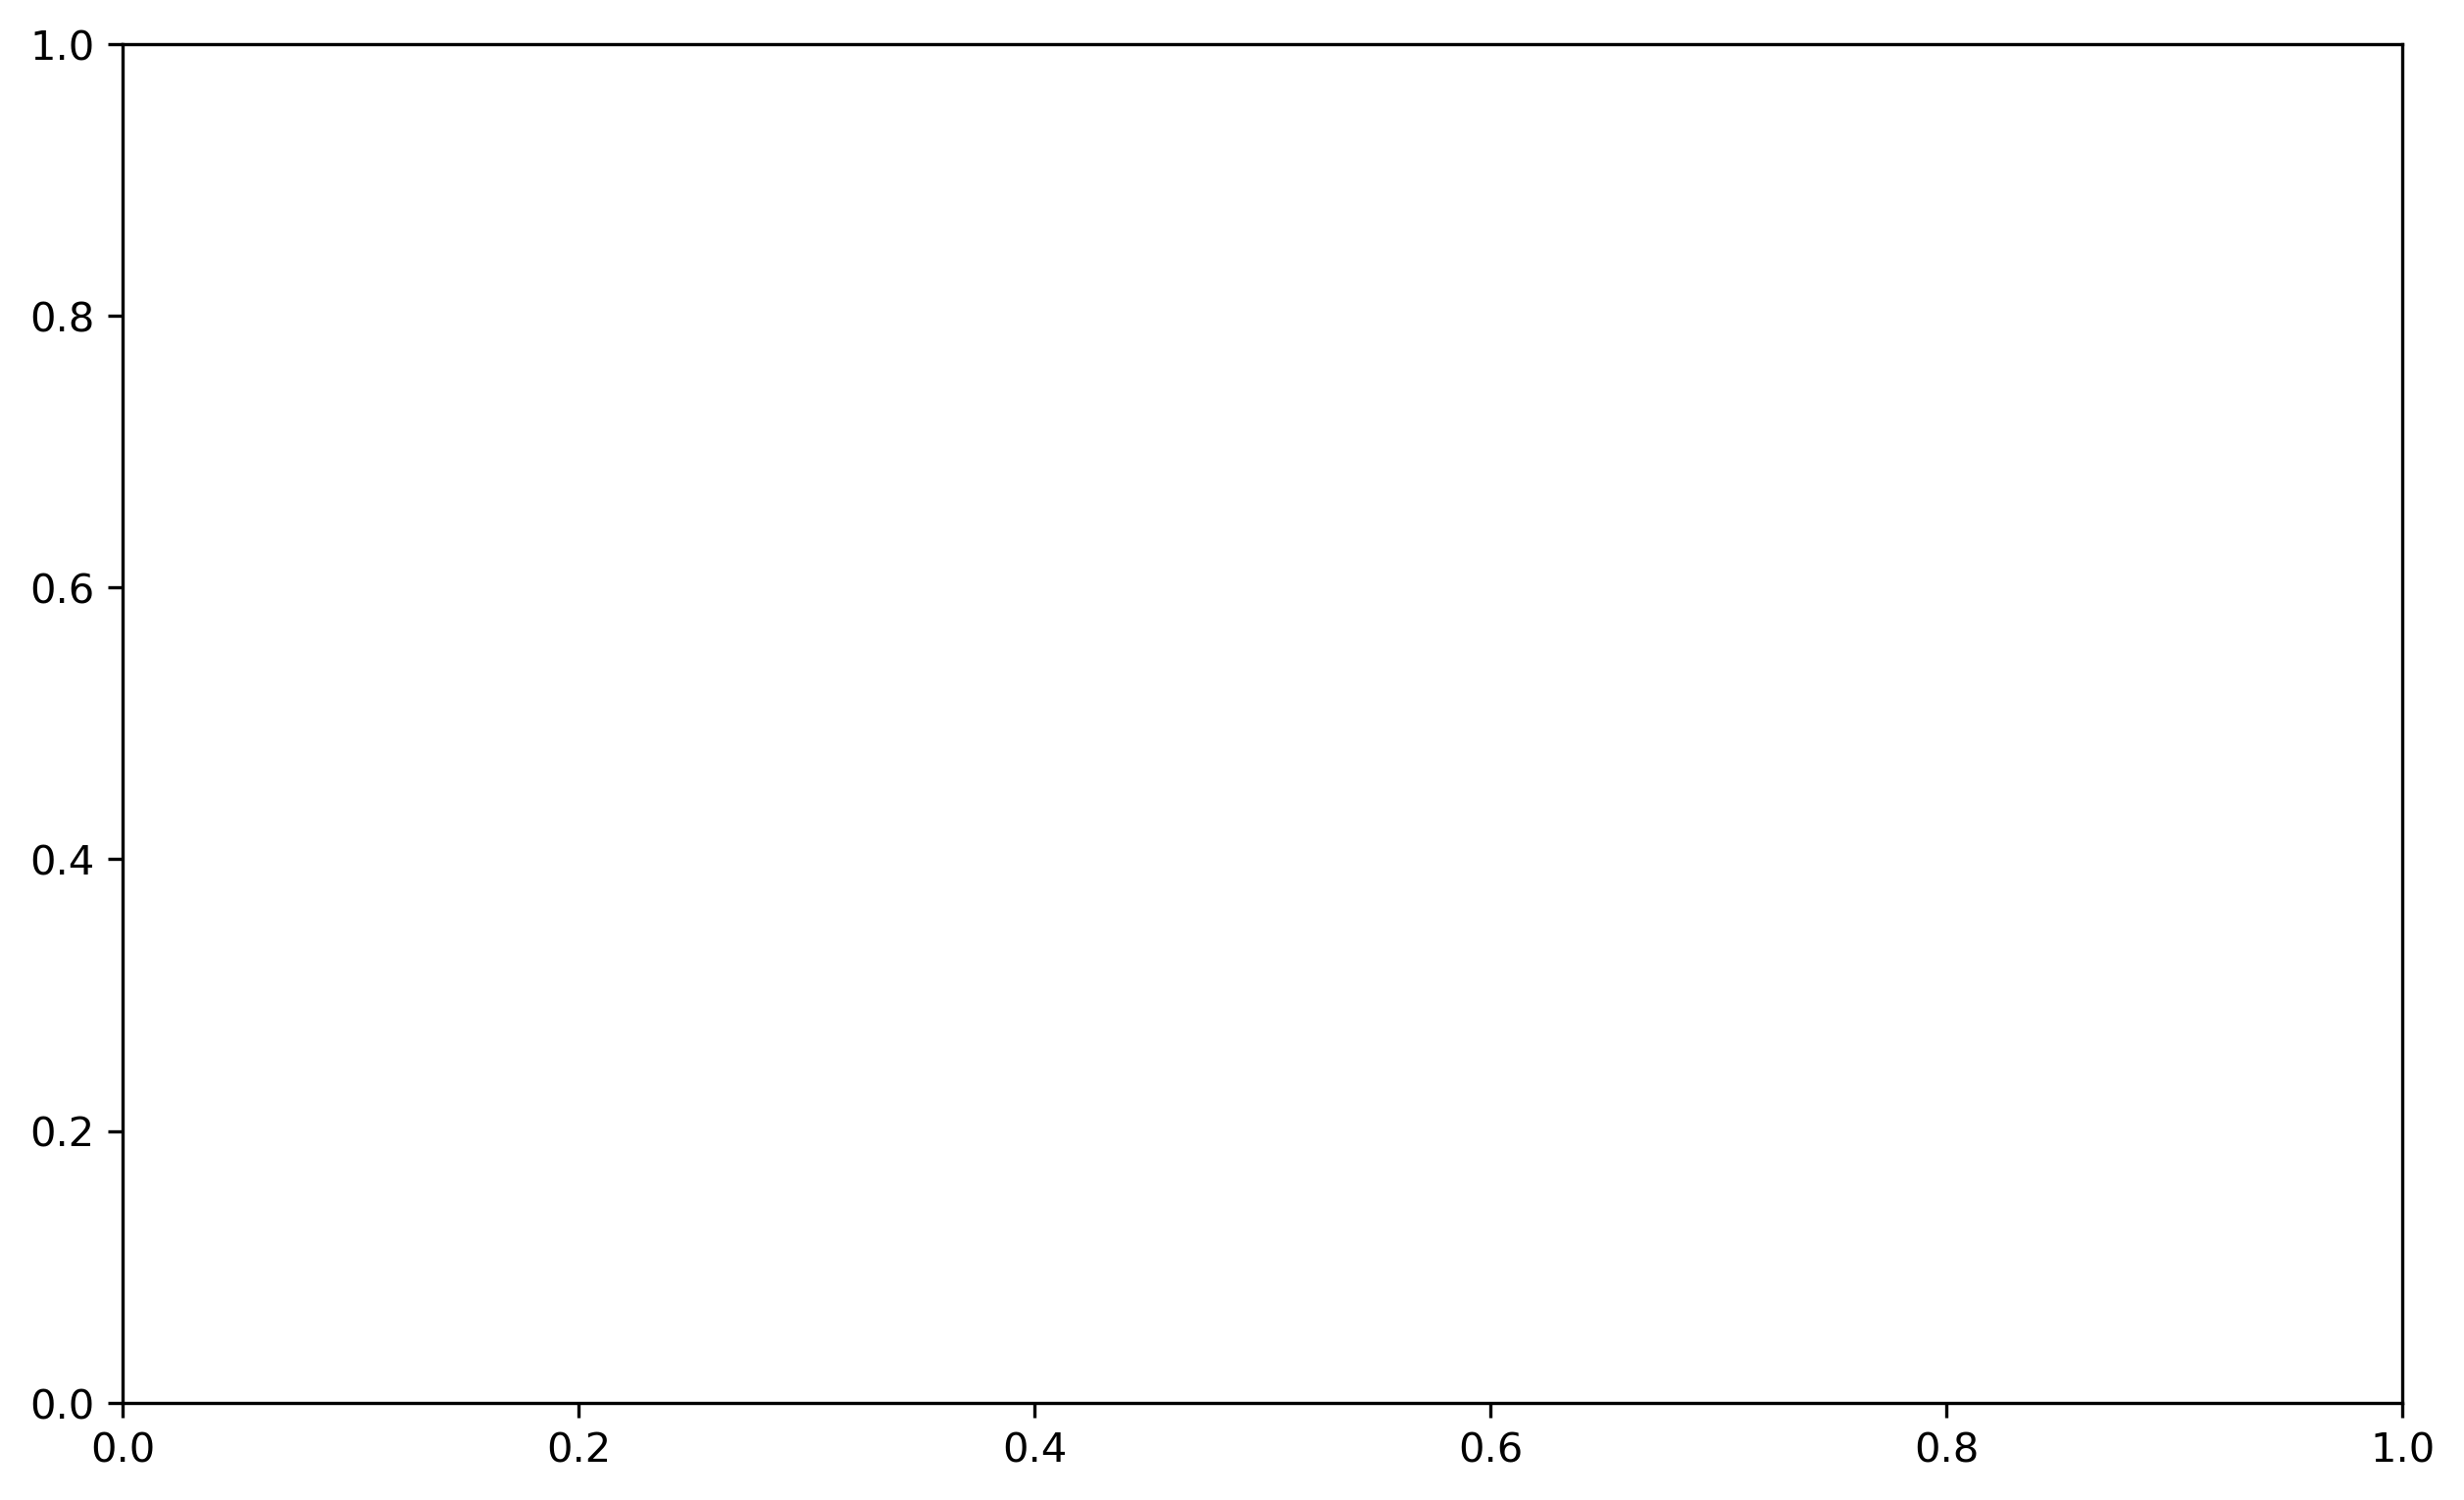

In [8]:
plot_combined_cost_distribution(15,300)

## Waterfall Chart

In [12]:
test= 'Vientiane LCOH - trucking battery costs portion'

In [16]:
test.split(" - ")[1].split(" ")[1]

'battery'

In [13]:
label = [test.split(" - ")[1].replace(f' trucking', '').replace(' portion', '')] + ["Total"]

label

['trucking battery costs', 'Total']

In [160]:
# def generate_waterfall_chart(gdf, transport_type):
#     # Find the min-cost hexagon in the pipeline or trucking data
#     min_hexagon = gdf.loc[gdf[f'Vientiane {transport_type} production cost'].idxmin()]

#     # Define the columns for the cost breakdown
#     columns = [
#         f'Vientiane LCOH - {transport_type} battery costs portion',
#         f'Vientiane LCOH - {transport_type} electrolyzer portion',
#         f'Vientiane LCOH - {transport_type} H2 storage portion',
#         f'Vientiane LCOH - {transport_type} wind portion',
#         f'Vientiane LCOH - {transport_type} solar portion',
#         f'Vientiane LCOH - {transport_type} hydro portion'
#     ]

#     # Extract the actual cost values from the selected hexagon
#     cost_values = {col: min_hexagon[col] for col in columns}

#     # Calculate total LCOH cost for the transport method
#     total_cost = min_hexagon[f'Vientiane {transport_type} production cost']

#     # Create lists for the waterfall chart
#     measures = ["relative"] * len(columns) + ["total"]
#     labels = [col.split(" - ")[1].replace(f' {transport_type}', '').replace(' portion', '') for col in columns] + ["Total"]
#     values = list(cost_values.values()) + [0]  # 0 for total, as it will be auto-calculated
#     texts = [f"{value:.2f}" for value in cost_values.values()] + [f"{total_cost:.2f}"]

#     # Create the waterfall chart with improved aesthetics
#     fig = go.Figure(go.Waterfall(
#         name="LCOH Cost Breakdown",  # Removed transport type from title
#         orientation="v",
#         measure=measures,
#         x=labels,
#         y=values,
#         text=texts,
#         connector={"line": {"color": "rgb(63, 63, 63)", "dash": "dot"}},
#         increasing={"marker": {"color": "#0000ff"}},  # Blue color for increasing
#         decreasing={"marker": {"color": "#ff7f0e"}},  # Orange color for decreasing
#         totals={"marker": {"color": "#000000"}}  # Black color for total
#     ))

#     # Update layout to increase font sizes and improve the overall look
#     fig.update_layout(
#         # title=f"{transport_type.capitalize()} LCOH Cost Breakdown",
#         xaxis_title="Cost Portions",
#         yaxis_title="LCOH [USD/kgH2]",
#         xaxis=dict(
#             tickfont=dict(color='black', size=20),  # Increased x-axis tick labels font size
#             titlefont=dict(color='black', size=22),  # Increased x-axis title font size
#         ),
#         yaxis=dict(
#             tickfont=dict(color='black', size=20),  # Increased y-axis tick labels font size
#             titlefont=dict(color='black', size=22),  # Increased y-axis title font size
#             showgrid=True,
#             gridcolor='lightgrey'  # Light grey grid lines for y-axis
#         ),
#         plot_bgcolor='white',  # Set plot background color to white
#         showlegend=False,
#         width=900,
#         height=600,
#         font=dict(size=18),  # General font size increase
#         margin=dict(l=50, r=50, t=100, b=50)
#     )

#     # Show the plot
#     fig.show()

In [169]:
def generate_waterfall_chart(gdf, transport_type):
    # Find the min-cost hexagon in the pipeline or trucking data
    min_hexagon = gdf.loc[gdf[f'Vientiane {transport_type} production cost'].idxmin()]

    # Define the columns and their corresponding custom labels
    columns_and_labels = [
        (f'Vientiane LCOH - {transport_type} battery costs portion', 'Battery'),
        (f'Vientiane LCOH - {transport_type} electrolyzer portion', 'Electrolyzer'),
        (f'Vientiane LCOH - {transport_type} H2 storage portion', 'H2 Storage'),
        (f'Vientiane LCOH - {transport_type} wind portion', 'Wind'),
        (f'Vientiane LCOH - {transport_type} solar portion', 'Solar'),
        (f'Vientiane LCOH - {transport_type} hydro portion', 'Hydro')
    ]

    # Extract columns and labels
    columns = [item[0] for item in columns_and_labels]
    labels = [item[1] for item in columns_and_labels] + ["Total"]

    # Extract the actual cost values from the selected hexagon
    cost_values = {col: min_hexagon[col] for col in columns}

    # Calculate total LCOH cost for the transport method
    total_cost = min_hexagon[f'Vientiane {transport_type} production cost']

    # Create lists for the waterfall chart
    measures = ["relative"] * len(columns) + ["total"]
    values = list(cost_values.values()) + [0]  # 0 for total, as it will be auto-calculated
    texts = [f"{value:.2f}" for value in cost_values.values()] + [f"{total_cost:.2f}"]

    # Rest of the function remains the same
    fig = go.Figure(go.Waterfall(
        # name="LCOH Cost Breakdown",
        orientation="v",
        measure=measures,
        x=labels,
        y=values,
        text=texts,
        connector={"line": {"color": "rgb(63, 63, 63)", "dash": "dot"}},
        increasing={"marker": {"color": "#0000ff"}},
        decreasing={"marker": {"color": "#ff7f0e"}},
        totals={"marker": {"color": "#000000"}}
    ))

    fig.update_layout(
        xaxis_title="Cost Portions",
        yaxis_title="LCOH [USD/kgH2]",
        xaxis=dict(
            tickfont=dict(color='black', size=20),
            titlefont=dict(color='black', size=22),
        ),
        yaxis=dict(
            tickfont=dict(color='black', size=20),
            titlefont=dict(color='black', size=22),
            showgrid=True,
            gridcolor='lightgrey'
        ),
        plot_bgcolor='white',
        showlegend=False,
        width=550,
        height=500,
        font=dict(size=18),
        margin=dict(l=50, r=50, t=100, b=50)
    )

    fig.show()

In [170]:
generate_waterfall_chart(gdf_data, 'trucking')

In [ ]:
'pipeline production cost',
'pipeline solar capacity',
'pipeline wind capacity',
'pipeline hydro capacity',
'pipeline electrolyzer capacity',
'pipeline battery capacity',
'pipeline H2 storage capacity',